# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Train/Test Split](#4.5_Train/Test_Split)
  * [4.6 Scaling data](#4.6_Scaling_data)
  * [4.7 Models](#4.7_Initial_Models)
    * [4.7.1 Define required functions to fit models and evaluate their performances](#4.7.1_Define_required_functions_to_fit_models_and_evaluate_their_performances)
    * [4.7.2 Models with all features](#4.7.2_Models_with_all_features)
    * [4.7.3 Models with selected features](#4.7.3_Models_with_selected_features)
  * [4.8 Models Perfomance](#4.8_Models_Perfomance)
  * [4.9 Final Model Selection](#4.9_Final_Model_Selection)    
  * [4.10 Save best model object](#4.10_Save_best_model_object)
  


## 4.2 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, performed preliminary assessments of data quality. The detecting the abnormal ecgs was the primary aim. 

In this notebook we'll start to build machine learning models including Logistic regression, Random Forest Calssifier, and k nearest neighbour. Then, the process of efficiently and robustly creating and assessing models will be performed. 

## 4.3 Imports<a id='4.3_Imports'></a>

In [91]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

import datetime

from library.sb_utils import save_file

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [92]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features.csv')
ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


In [93]:
ecg_data.Target = ecg_data.Target.astype('int')
ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


## 4.5 Train/Test Split<a id='4.5_Train/Test_Split'></a>

In [94]:
# Define a function to split the dataset into train and test parts
def Split_Dataset_Train_Test(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Target'), 
                                                        data.Target, test_size=0.2,
                                                        stratify= data.Target,random_state=47)

    return  X_train, X_test, y_train, y_test

In [95]:
# check if the dataset is balanced
ecg_data.Target.value_counts(normalize=True)*100

1    58.403361
0    41.596639
Name: Target, dtype: float64

In [96]:
X_train, X_test, y_train, y_test = Split_Dataset_Train_Test(ecg_data)

In [97]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((3998, 140), (3998,), (1000, 140), (1000,))

## 4.6 Scaling data<a id='4.6_Scaling_data'></a>

In [98]:
# https://towardsdatascience.com/data-leakage-in-machine-learning-6161c167e8ba
# https://stats.stackexchange.com/questions/569024/when-we-use-standardscaler-in-pipeline-with-gridsearchcv-does-it-automaticall

def scale_data(Scaler,X_train, X_test):
    sc = Scaler
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test


## 4.7 Models<a id='4.7_Models'></a>

### 4.7.1 Define required functions to fit models and evaluate their performances<a id='4.7.1_Define_required_functions_to_fit_models_and_evaluate_their_performances'></a>


In [99]:
# Show model's performance

def model_results(model, y_train, y_tr_pred, y_test, y_te_pred, show_training_result=True ):

    print( model)
    print('-------------------------------------')
    if show_training_result:
        print("Classification Report for Training Data")
        print(classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']))
    print('-------------------------------------')
    print("Classification Report for Test Data")
    print(classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']))


In [100]:
# Plot Model's ROC

def plot_ROC(model,X, y, title_method ):
    
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{} (area = {:2.2%})'.format(title_method,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [101]:
#  train and test a model 

def train_test_model(model, grid_params, X_train, y_train, X_test, y_test, model_name):
    pipe = make_pipeline(
    StandardScaler(),
    model
    )

    rskf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=True)
    model_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=rskf, n_jobs=-1)
    model_grid_cv.fit(X_train, y_train)
    
    y_tr_pred = model_grid_cv.predict(X_train)
    y_te_pred = model_grid_cv.predict(X_test)
    


    if model_name in ['Random Forest', 'K_Neighbors', 'Logistic Regression'] :
        show_training_result = False
    else:
        show_training_result= True
    model_results(model_name, y_train, y_tr_pred, y_test, y_te_pred,show_training_result )  
    plot_ROC(model_grid_cv, X_test, y_test, model_name)

    row_model = {'model_name':model_name, 'Accuracy on training data':accuracy_score(y_tr_pred, y_train), 'Accuracy on test data':accuracy_score(y_te_pred, y_test),
'Precision score on training data':precision_score(y_train, y_tr_pred,  pos_label=0), 'Precision score  on test data':precision_score( y_test, y_te_pred,  pos_label=0), 
'Recall score on training data':recall_score(y_train, y_tr_pred, pos_label=1),  'Recall score  on test data':recall_score( y_test, y_te_pred, pos_label=1), 
'F1 score on training data':f1_score(y_train, y_tr_pred, pos_label =0 ), 'F1 score  on test data':f1_score( y_test, y_te_pred, pos_label=1), 
'Classification Report for Training Data':classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']), 
'Classification Report for Test Data':classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']), 
'best_params_':model_grid_cv.best_params_

    }
    return(row_model) 



Three machine learning algorithms for classification problems, including: logistic regression, random forest, and k nearest neighbour are applied on the train dataset. Then, the performances of these models are evaluated using metrics Accuracy, Precision, Recall, and F1 score and plotting Receiver-Operator Curve (ROC Curve) and calculating Area Under the Curve (AUC).

In [113]:
def apply_evaluate_models(data):
    X_train, X_test, y_train, y_test = Split_Dataset_Train_Test(data)

    # define 3 models LogisticRegression, RandomForestClassifier, and KNeighborsClassifier and their parameters
    params = [
        {'classifier' : [LogisticRegression()], 'model_name' : ['Logistic Regression'],
        'param_grid': { 'logisticregression__penalty' : ['l1', 'l2', None], 'logisticregression__C' : np.logspace(-3,3,7), 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}},
        {'classifier' : [RandomForestClassifier()], 'model_name' : ['Random Forest'],
        'param_grid': { 'randomforestclassifier__n_estimators' : list(range(10,100,200)), 'randomforestclassifier__max_depth' : [4,5,6,7,8], 'randomforestclassifier__criterion' :['gini', 'entropy']}}, 
        {'classifier' : [KNeighborsClassifier()], 'model_name' : ['K_Neighbors'],
        'param_grid': { 'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}}
    ]


    # define a dataframe to save performance metrics
    df_results = pd.DataFrame(columns=['model_name', 'Accuracy on training data', 'Accuracy on test data',
    'Precision score on training data', 'Precision score  on test data', 
    'Recall score on training data', 'Recall score  on test data', 
    'F1 score on training data', 'F1 score  on test data', 
    'Classification Report for Training Data', 
    'Classification Report for Test Data', 
    'best_params_'])

    # train and test models
    for model_params in params:
        model = model_params['classifier'][0]
        param_grid = model_params['param_grid']
        model_name = model_params['model_name'][0]
        result = train_test_model(model, param_grid, X_train, y_train, X_test, y_test, model_name)
        
        df_results.loc[len(df_results.index)] = result

    return df_results


### 4.7.1 Models using all features<a id='4.7.1_Models_with_all_features'></a>




Split Ecg with all features into train and test, fitting models on the train part, evaluate models' performances

(3998, 140) (3998,) (1000, 140) (1000,)
Logistic Regression
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.98      0.98       416
      NORMAL       0.98      0.99      0.99       584

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



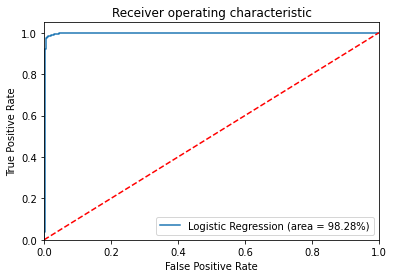

Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.98      0.99       416
      NORMAL       0.99      1.00      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



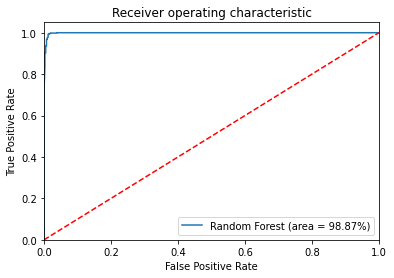

K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.99      0.99       416
      NORMAL       0.99      0.99      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



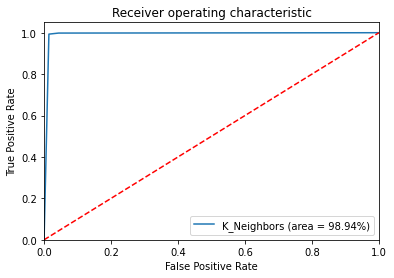

In [112]:
df_results = apply_evaluate_models(ecg_data)

Models performances

In [114]:
pd.set_option('display.max_colwidth', 3000)
df_results.iloc[:, [0, 2, 4,6,8,11]]

,model_name,Accuracy on test data,Precision score on test data,Recall score on test data,F1 score on test data,best_params_
0,Logistic Regression,0.984,0.985437,0.989726,0.986348,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}"
1,Random Forest,0.990,0.995122,0.996575,0.991482,"{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 10}"
2,K_Neighbors,0.990,0.990338,0.993151,0.991453,"{'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'uniform'}"


As it can be seen the models performance might be "too good to be true". In order to investigate whether this is an artifact of of software bugs of data issues, the code was examined looking for possible bugs but not found any error. Then, some approaches were examined to discover a single leaking feature which were not successful. At the end, a subset of the features not including high correlated features is used for further analisysthe.

### 4.7.3 Models with selected features<a id='4.7.3_Models_with_selected_features'></a>

In previous notbook, a datset was built which consists of features with corrolation lower than 85 percent with Target variable. In this section, this dataset is used to evaluate the models perfomance.

In [121]:
ecg_data_selected = pd.read_csv('../data/ecg_data_step3_features_uncorrelated85.csv')
print('\ndataset shape:', ecg_data_selected.shape)


dataset shape: (4998, 6)


In [120]:
ecg_data_selected.head()

,t0,t1,t6,t7,t139,Target
0,-0.112522,-2.827204,-2.181408,-1.818287,0.193137,1.0
1,-1.100878,-3.996840,-1.566126,-0.992258,-1.436250,1.0
2,-0.567088,-2.593450,-1.742940,-1.490658,-0.421797,1.0
3,0.490473,-1.914407,-2.993280,-1.671131,-0.383564,1.0
4,0.800232,-0.874252,-2.534510,-1.783423,1.421456,1.0


Correlation between Target and other features in the dataset 

In [123]:
ecg_data_selected.corr()['Target'][:].abs().T

t0        0.114752
t1        0.455028
t6        0.015209
t7        0.326290
t139      0.151506
Target    1.000000
Name: Target, dtype: float64

Logistic Regression
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.92      0.88      0.90       416
      NORMAL       0.92      0.94      0.93       584

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.92      0.92      0.92      1000



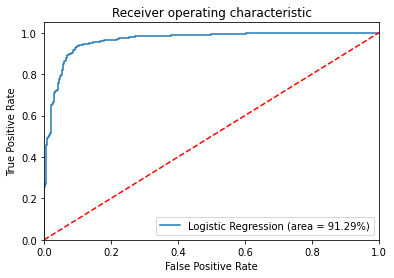

Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.95      0.92      0.94       416
      NORMAL       0.94      0.97      0.96       584

    accuracy                           0.95      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000



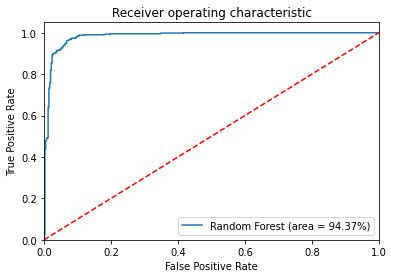

K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.94      0.94       416
      NORMAL       0.96      0.95      0.95       584

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



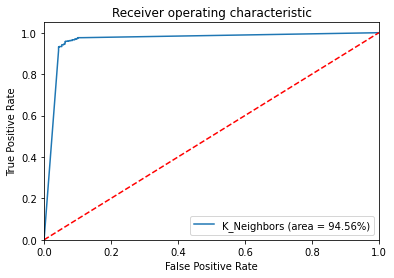

In [125]:
df_results = apply_evaluate_models(ecg_data_selected)

Models performances

In [126]:
df_results.iloc[:, [0, 2, 4,6,8,11]]

,model_name,Accuracy on test data,Precision score on test data,Recall score on test data,F1 score on test data,best_params_
0,Logistic Regression,0.918,0.917500,0.943493,0.930743,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}"
1,Random Forest,0.948,0.955000,0.969178,0.956081,"{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 10}"
2,K_Neighbors,0.947,0.935252,0.953767,0.954584,"{'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'distance'}"


## 4.9 Final Model Selection<a id='4.9_Final_Model_Selection'></a>

For further analisys, additional models will be built in the "Modeling" notebook and the models performance will be examined.